# **Library Imports**

In [5]:
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.models import vgg16
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import resnet
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import copy
from torch.utils.data import Subset
import random
import os
import pickle
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import kagglehub

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
import os
from PIL import Image
from torchvision.datasets import MNIST, SVHN, USPS
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [38]:
# Define paths for MNIST, SVHN, and USPS
mnist_path = '/content/dataset/mnist'
svhn_path = '/content/dataset/svhn'
usps_path = '/content/dataset/usps'

# Define transformations for the datasets
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3 channels
])



# Function to load MNIST dataset
def load_mnist_dataset(root, transform):
    dataset = MNIST(root=root, train=True, download=True, transform=transform)
    return dataset

# Function to load SVHN dataset
def load_svhn_dataset(root, transform):
    dataset = SVHN(root=root, split='train', download=True, transform=transform)
    return dataset

# Function to load USPS dataset
def load_usps_dataset(root, transform):
    dataset = USPS(root=root, train=True, download=True, transform=transform)
    return dataset

# Load datasets
mnist_dataset = load_mnist_dataset(mnist_path, transform)
svhn_dataset = load_svhn_dataset(svhn_path, transform)
usps_dataset = load_usps_dataset(usps_path, transform)

# Combine datasets into loaders
def create_digit_train_test_dataloader(dataset, batch_size=32, test_size=0.2, shuffle=True):
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Create DataLoaders for MNIST, SVHN, and USPS
mnist_train_loader, mnist_test_loader = create_digit_train_test_dataloader(mnist_dataset)
svhn_train_loader, svhn_test_loader = create_digit_train_test_dataloader(svhn_dataset)
usps_train_loader, usps_test_loader = create_digit_train_test_dataloader(usps_dataset)

# Combine train DataLoaders
train_dataloaders = {
    "mnist": mnist_train_loader,
    "svhn": svhn_train_loader,
    "usps": usps_train_loader
}

# Combine test DataLoaders
test_dataloaders = {
    "mnist": mnist_test_loader,
    "svhn": svhn_test_loader,
    "usps": usps_test_loader
}

print("MNIST, SVHN, and USPS DataLoaders created successfully.")

# Function to visualize images
def visualize_same_label_across_domains(dataloaders, label_to_check, num_images_per_domain=5):
    """
    Visualize images of the same label across different domains.
    """
    fig, axes = plt.subplots(len(dataloaders), num_images_per_domain, figsize=(15, 10))
    fig.suptitle(f"Images with Label {label_to_check} Across Domains", fontsize=16)

    for i, (domain, dataloader) in enumerate(dataloaders.items()):
        domain_images_shown = 0
        for images, labels in dataloader:
            indices = (labels == label_to_check).nonzero(as_tuple=True)[0]
            for idx in indices[:num_images_per_domain - domain_images_shown]:
                ax = axes[i, domain_images_shown] if len(dataloaders) > 1 else axes[domain_images_shown]
                image = images[idx].permute(1, 2, 0).numpy()  # Convert to HxWxC
                image = (image * 0.5) + 0.5  # De-normalize
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(f"{domain}")
                domain_images_shown += 1
                if domain_images_shown >= num_images_per_domain:
                    break
            if domain_images_shown >= num_images_per_domain:
                break

    plt.tight_layout()
    plt.show()


Using downloaded and verified file: /content/dataset/svhn/train_32x32.mat
MNIST, SVHN, and USPS DataLoaders created successfully.


Visualizing Train Loaders


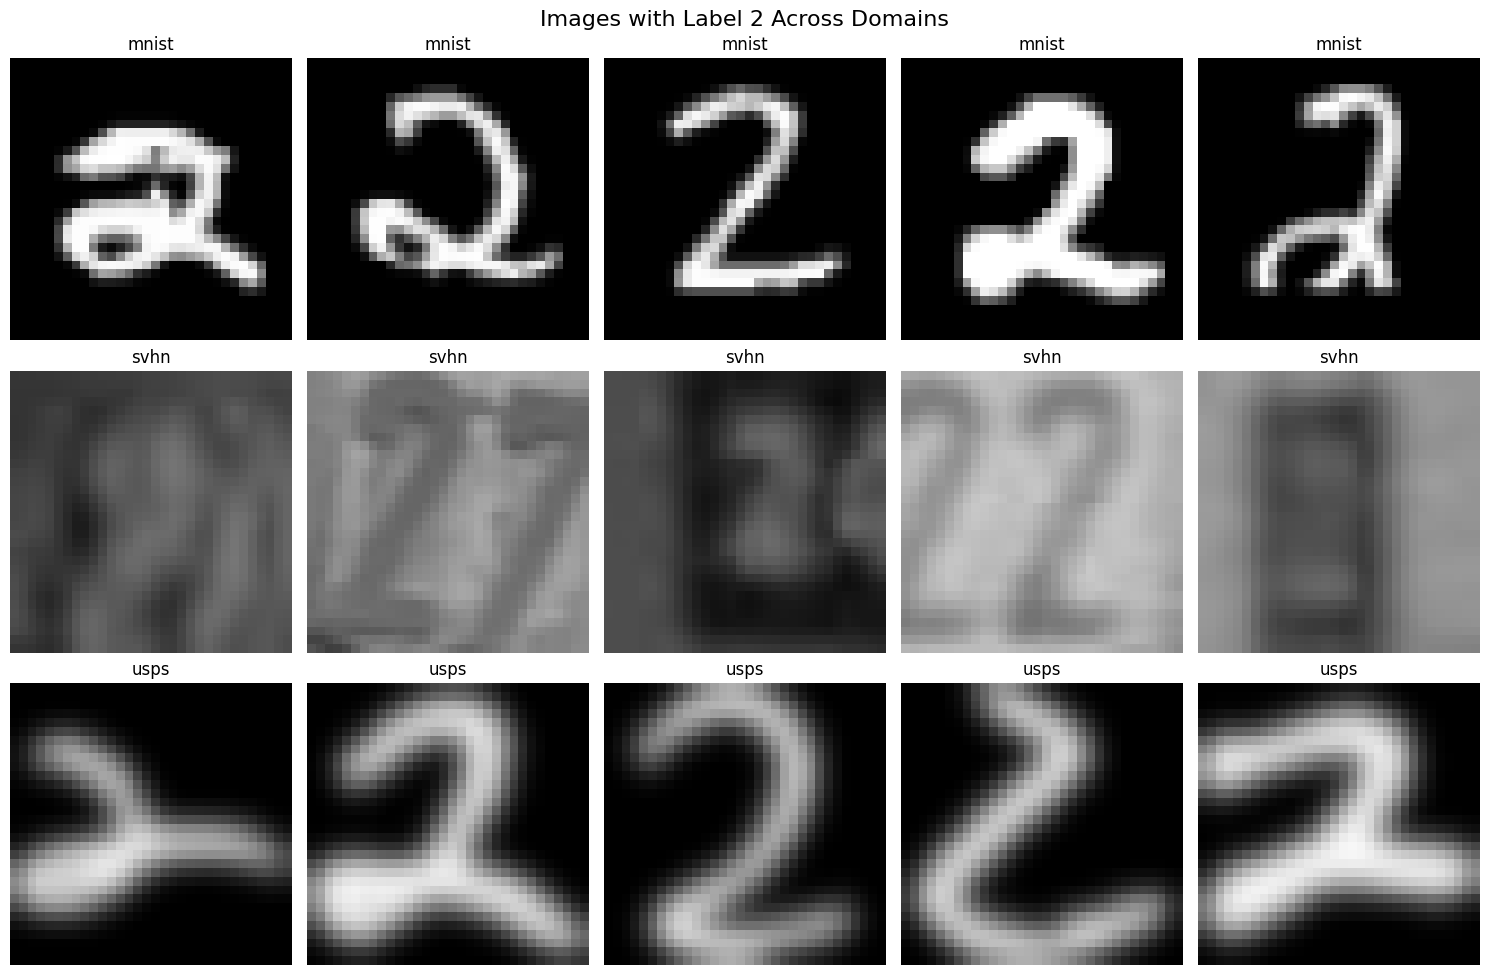

Visualizing Test Loaders


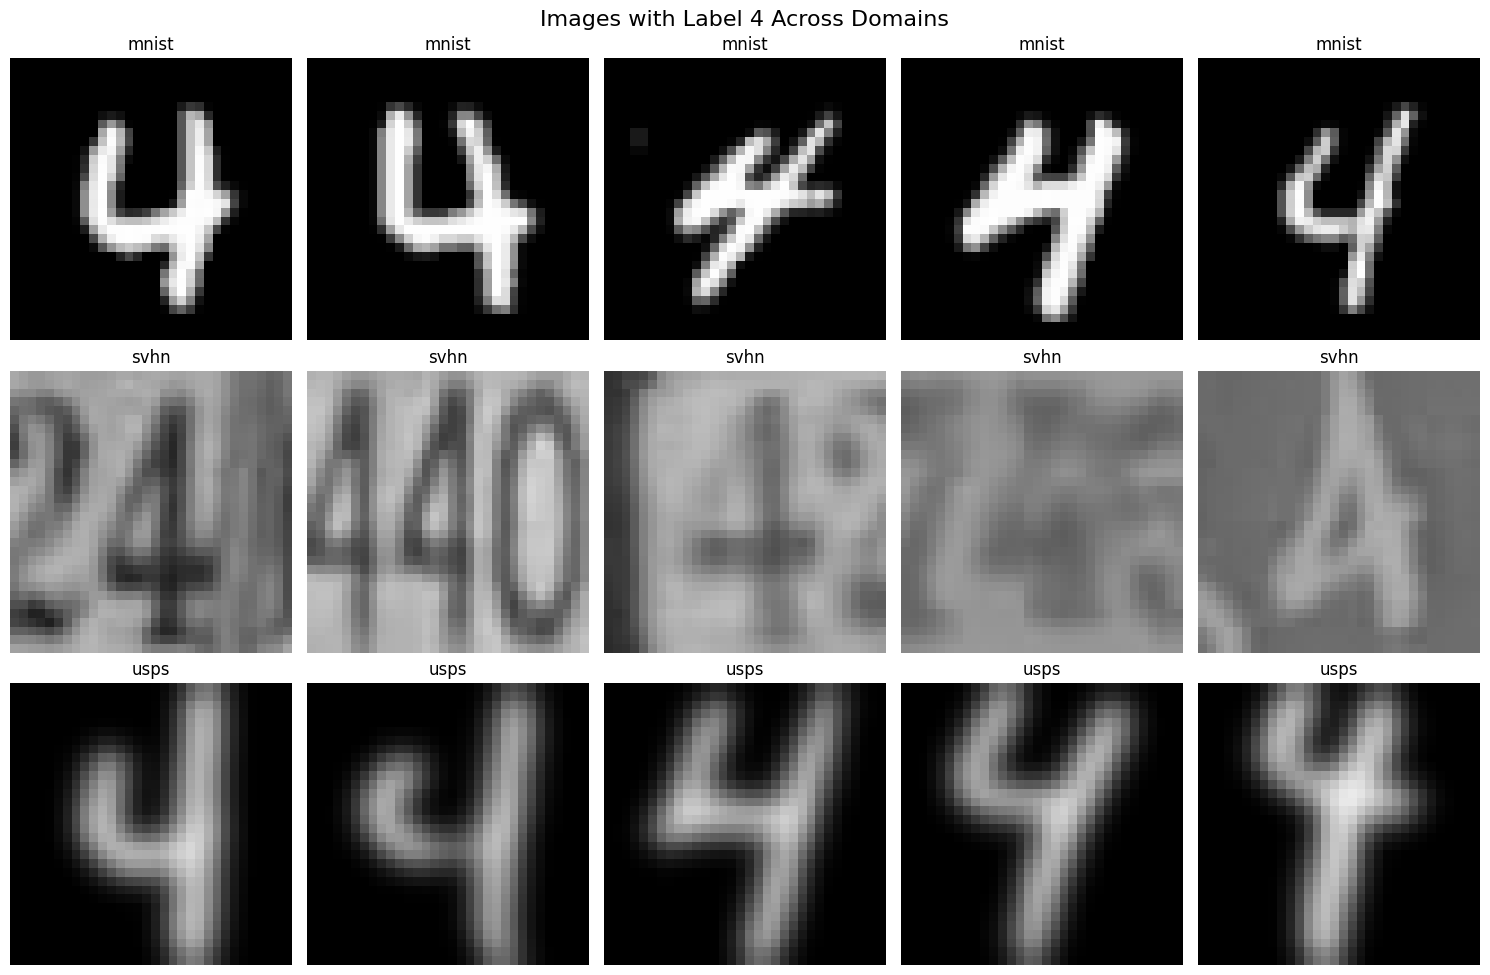

In [39]:
# Visualize samples from the datasets
print("Visualizing Train Loaders")
visualize_same_label_across_domains(train_dataloaders, label_to_check=2, num_images_per_domain=5)
print("Visualizing Test Loaders")
visualize_same_label_across_domains(test_dataloaders, label_to_check=4, num_images_per_domain=5)


# **Hyperparameters**

In [67]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 10
num_communication_rounds = 5
train_val_split = 0.8  # Percentage of data for training

# Training ratios and class ratios for each dataset
base_training_ratios = {
    'mnist': 0.75,
    'svhn': 0.75,
    'usps': 0.75
}

class_ratios = {
    domain: {i: 0.01 for i in range(10)} for domain in base_training_ratios.keys()
}


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# **Data Preparation and Dataset Loading**

In [68]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3 channels
])



# Placeholder paths for datasets
mnist_path = '/content/dataset/mnist'
svhn_path = '/content/dataset/svhn'
usps_path = '/content/dataset/usps'

dataset_paths = {
    'mnist': mnist_path,
    'svhn': svhn_path,
    'usps': usps_path
}

# Function to load MNIST dataset
def load_mnist_dataset(root, transform):
    from torchvision.datasets import MNIST
    dataset = MNIST(root=root, train=True, download=True, transform=transform)
    return dataset

# Function to load SVHN dataset
def load_svhn_dataset(root, transform):
    from torchvision.datasets import SVHN
    dataset = SVHN(root=root, split='train', download=True, transform=transform)
    return dataset

# Function to load USPS dataset
def load_usps_dataset(root, transform):
    from torchvision.datasets import USPS
    dataset = USPS(root=root, train=True, download=True, transform=transform)
    return dataset

# Load datasets
datasets = {
    'mnist': load_mnist_dataset(dataset_paths['mnist'], transform),
    'svhn': load_svhn_dataset(dataset_paths['svhn'], transform),
    'usps': load_usps_dataset(dataset_paths['usps'], transform)
}

# Create test loaders
test_dataloaders = {
    domain: DataLoader(datasets[domain], batch_size=128, shuffle=False)
    for domain in datasets.keys()
}


Using downloaded and verified file: /content/dataset/svhn/train_32x32.mat


# **Dataset Sorting and Dynamic Dataset Creation**

In [69]:
def sort_by_class(dataset, num_classes=10):
    """
    Sort dataset samples by class labels.
    """
    sorted_data = {i: [] for i in range(num_classes)}
    for idx in range(len(dataset)):
        image, label = dataset[idx]  # PyTorch datasets return (image, label)
        sorted_data[label].append((image, label))  # Append the tuple
    return sorted_data

def create_dynamic_dataset(sorted_data, ratio_size, class_ratios, num_classes=10):
    """
    Create a dynamic dataset with samples proportional to the class_ratios.
    """
    dynamic_dataset = []
    total_size = int(sum(len(v) for v in sorted_data.values()) * ratio_size)
    for class_label in range(num_classes):
        # Default ratio is evenly distributed across classes
        ratio = class_ratios.get(class_label, 1 / num_classes)
        num_samples = min(int(total_size * ratio), len(sorted_data[class_label]))
        sampled_data = random.sample(sorted_data[class_label], num_samples)
        dynamic_dataset.extend(sampled_data)
    return dynamic_dataset

# Sort datasets by class
sorted_datasets = {
    domain: sort_by_class(datasets[domain], 10) for domain in datasets.keys()
}


# **Model Definition - SimpleCNN**

In [70]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Add pooling to reduce spatial size
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust dimensions after pooling
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))  # Pooling added here
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# **Local Training Function**

In [71]:
def local_train(model, dataset_name, training_ratios, class_ratios, criterion, optimizer, epochs):
    model.train()

    # Create dataset dynamically based on training ratios and class_ratios
    sorted_data = sorted_datasets[dataset_name]
    dynamic_dataset = create_dynamic_dataset(sorted_data, training_ratios[dataset_name], class_ratios[dataset_name])
    dataloader = DataLoader(dynamic_dataset, batch_size=batch_size, shuffle=True)

    dataset_size = len(dataloader.dataset)
    train_size = int(train_val_split * dataset_size)
    val_size = dataset_size - train_size

    train_dataset, val_dataset = random_split(dataloader.dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        for images, labels in tqdm(train_loader, desc=f"{dataset_name} Training Local Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    num_classes = 10  # Adjust if necessary
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"{dataset_name} on Validation dataset"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Validate label ranges
            for i in range(len(labels)):
                label = labels[i].item()
                if label < num_classes:  # Ensure label is within range
                    class_correct[label] += (predicted[i] == labels[i]).item()
                    class_total[label] += 1

    overall_acc = 100 * correct / total
    class_acc = [
        100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        for i in range(num_classes)
    ]
    return model, overall_acc, class_acc


# **Model Testing Function**

In [72]:
def test_model(model, dataloader, name):
    model.eval()
    num_classes = 10  # Update to match the actual number of classes
    correct = 0
    total = 0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Testing {name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(labels)):
                label = labels[i].item()
                if label < num_classes:  # Ensure label is within range
                    class_correct[label] += (predicted[i] == labels[i]).item()
                    class_total[label] += 1

    overall_acc = 100 * correct / total
    class_acc = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return overall_acc, class_acc, class_correct, class_total


# **Fed Class Avg**

In [73]:
def fed_class_avg(models, accuracies=None):
    global_model = models[0]
    global_dict = global_model.state_dict()

    if accuracies:
        # Make weights directly proportional to accuracies
        weights = torch.tensor([accuracies[name]['overall'] for name in datasets.keys()], dtype=torch.float32)

        # Normalize the weights to sum up to 1
        weights /= weights.sum()
    else:
        # Assign equal weights if no accuracies are provided
        weights = torch.tensor([1.0 / len(models)] * len(models), dtype=torch.float32)

    # Update global model weights based on the proportional weights
    for key in global_dict.keys():
        weighted_sum = torch.zeros_like(global_dict[key])
        for i in range(len(models)):
            weighted_sum += weights[i] * models[i].state_dict()[key].float()
        global_dict[key] = weighted_sum

    # Load the updated weights into the global model
    global_model.load_state_dict(global_dict)
    return global_model


# **Displaying Dataset & Class Accuracies**

In [74]:
def display_accuracy_all(model, loaders, names):
    accuracies = {}
    num_classes = 10  # Update to match the actual number of classes
    total_correct = [0] * num_classes
    total_count = [0] * num_classes

    print("====================Starting Testing on Test Dataset======================")
    for loader, name in zip(loaders, names):
        overall, class_acc, correct, count = test_model(model, loader, name)
        accuracies[name] = {'overall': overall, 'class_acc': class_acc}
        print(f"{name} Overall Accuracy: {overall:.2f}%")
        for i in range(num_classes):
            total_correct[i] += correct[i]
            total_count[i] += count[i]
            print(f"{name} Accuracy for Class {i}: {class_acc[i]:.2f}%")

    combined_accuracy = sum(total_correct) / sum(total_count) * 100
    print(f"Overall Accuracy Across All Datasets: {combined_accuracy:.2f}%")
    print("====================Ending Testing on Test Dataset======================")
    return accuracies


# **Training Loop with Communication Rounds**

In [75]:
models = [SimpleCNN(input_channels=3).to(device) for _ in range(len(datasets))]
criterions = [nn.CrossEntropyLoss() for _ in range(len(datasets))]
optimizers = [torch.optim.Adam(models[i].parameters(), lr=learning_rate) for i in range(len(datasets))]
names = list(datasets.keys())

accuracies = None
test_accuracies = []
training_ratios = base_training_ratios.copy()

for no_communication in range(num_communication_rounds):
    print(f"Communication Round {no_communication+1}/{num_communication_rounds}")

    # Train each model for the specified dataset
    models[0], mnist_overall_acc, mnist_class_acc = local_train(models[0], 'mnist', training_ratios, class_ratios, criterions[0], optimizers[0], num_epochs)
    models[1], svhn_overall_acc, svhn_class_acc = local_train(models[1], 'svhn', training_ratios, class_ratios, criterions[1], optimizers[1], num_epochs)
    models[2], usps_overall_acc, usps_class_acc = local_train(models[2], 'usps', training_ratios, class_ratios, criterions[2], optimizers[2], num_epochs)

    accuracies = {}
    accuracies['mnist'] = {'overall': mnist_overall_acc, 'class_acc': mnist_class_acc}
    accuracies['svhn'] = {'overall': svhn_overall_acc, 'class_acc': svhn_class_acc}
    accuracies['usps'] = {'overall': usps_overall_acc, 'class_acc': usps_class_acc}
    print("accuracies =", accuracies)

    global_model = fed_class_avg(models, accuracies)
    loaders = [test_dataloaders[domain] for domain in datasets.keys()]

    test_acc = display_accuracy_all(global_model, loaders, names)
    test_accuracies.append(test_acc)

    for i in range(len(models)):
        models[i].load_state_dict(global_model.state_dict())

    weights = torch.tensor([1 / max(accuracies[name]['overall'], 1e-6) for name in ['mnist', 'svhn', 'usps']], dtype=torch.float32)
    print("Testing Weights 1 (before normalization):", weights)
    weights /= weights.sum()
    print("Testing Weights 2 (after normalization):", weights)

    print("base_training_ratios =", base_training_ratios)
    additional_size = 0.2
    base_ratios = torch.tensor([base_training_ratios['mnist'], base_training_ratios['svhn'], base_training_ratios['usps']], dtype=torch.float32)
    weights = torch.tensor([1 / max(accuracies[name]['overall'], 1e-6) for name in ['mnist', 'svhn', 'usps']], dtype=torch.float32)
    weights /= weights.sum()
    scaled_addition = weights * additional_size
    new_ratios = base_ratios + scaled_addition

    new_training_ratios = {}
    new_training_ratios['mnist'] = new_ratios[0].item()
    new_training_ratios['svhn'] = new_ratios[1].item()
    new_training_ratios['usps'] = new_ratios[2].item()

    print("new_training_ratios:", new_training_ratios)

    base_ratio = 0.3
    for dataset in ['mnist', 'svhn', 'usps']:
        class_acc = accuracies[dataset]['class_acc']
        weights = torch.tensor([1 / acc if acc > 0 else 1.0 for acc in class_acc], dtype=torch.float32)
        weights /= weights.sum()
        dynamic_class_ratios = [base_ratio / 10 + (1 - base_ratio) * w.item() for w in weights]
        class_ratios[dataset] = {i: dynamic_class_ratios[i] for i in range(10)}

    print("Updated Class Ratios:", class_ratios)


Communication Round 1/5


usps on Validation dataset: 100%|██████████| 1/1 [00:00<00:00, 77.41it/s]


accuracies = {'mnist': {'overall': 94.88888888888889, 'class_acc': [97.82608695652173, 97.43589743589743, 90.38461538461539, 91.56626506024097, 91.56626506024097, 94.31818181818181, 96.3963963963964, 97.36842105263158, 98.01980198019803, 94.04761904761905]}, 'svhn': {'overall': 76.1384335154827, 'class_acc': [80.17241379310344, 77.11864406779661, 75.92592592592592, 66.3716814159292, 82.29166666666667, 72.07207207207207, 66.01941747572816, 88.59649122807018, 75.0, 77.66990291262135]}, 'usps': {'overall': 95.37037037037037, 'class_acc': [100.0, 100.0, 100.0, 92.3076923076923, 100.0, 91.66666666666667, 100.0, 100.0, 85.71428571428571, 83.33333333333333]}}
====================Starting Testing on Test Dataset======================


Testing mnist: 100%|██████████| 469/469 [00:31<00:00, 14.97it/s]


mnist Overall Accuracy: 23.01%
mnist Accuracy for Class 0: 0.02%
mnist Accuracy for Class 1: 34.57%
mnist Accuracy for Class 2: 99.46%
mnist Accuracy for Class 3: 0.00%
mnist Accuracy for Class 4: 46.22%
mnist Accuracy for Class 5: 0.00%
mnist Accuracy for Class 6: 0.00%
mnist Accuracy for Class 7: 42.19%
mnist Accuracy for Class 8: 3.52%
mnist Accuracy for Class 9: 0.00%


Testing svhn: 100%|██████████| 573/573 [00:38<00:00, 15.03it/s]


svhn Overall Accuracy: 15.12%
svhn Accuracy for Class 0: 0.00%
svhn Accuracy for Class 1: 0.37%
svhn Accuracy for Class 2: 90.03%
svhn Accuracy for Class 3: 0.00%
svhn Accuracy for Class 4: 3.14%
svhn Accuracy for Class 5: 0.00%
svhn Accuracy for Class 6: 0.00%
svhn Accuracy for Class 7: 0.82%
svhn Accuracy for Class 8: 24.02%
svhn Accuracy for Class 9: 0.00%


Testing usps: 100%|██████████| 57/57 [00:03<00:00, 17.03it/s]


usps Overall Accuracy: 12.08%
usps Accuracy for Class 0: 2.35%
usps Accuracy for Class 1: 3.78%
usps Accuracy for Class 2: 99.45%
usps Accuracy for Class 3: 0.00%
usps Accuracy for Class 4: 9.20%
usps Accuracy for Class 5: 0.00%
usps Accuracy for Class 6: 0.00%
usps Accuracy for Class 7: 0.00%
usps Accuracy for Class 8: 5.17%
usps Accuracy for Class 9: 0.00%
Overall Accuracy Across All Datasets: 18.33%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0105, 0.0131, 0.0105])
Testing Weights 2 (after normalization): tensor([0.3085, 0.3845, 0.3070])
base_training_ratios = {'mnist': 0.75, 'svhn': 0.75, 'usps': 0.75}
new_training_ratios: {'mnist': 0.8117051720619202, 'svhn': 0.8269011974334717, 'usps': 0.8113936185836792}
Updated Class Ratios: {'mnist': {0: 0.09784269511699675, 1: 0.09811437606811522, 2: 0.1034282650053501, 3: 0.10248068302869796, 4: 0.10248068302869796, 5: 0.10036591917276382, 6: 0.09884889304637909

usps on Validation dataset: 100%|██████████| 9/9 [00:00<00:00, 106.29it/s]


accuracies = {'mnist': {'overall': 98.54428269807757, 'class_acc': [98.98305084745763, 98.85714285714286, 97.99154334038055, 99.23664122137404, 98.2122905027933, 97.82135076252723, 98.84792626728111, 98.81796690307328, 98.2740021574973, 98.48156182212581]}, 'svhn': {'overall': 87.05849109918056, 'class_acc': [90.3, 84.93803622497617, 92.15686274509804, 88.7713588283157, 91.27134724857684, 83.53242320819113, 81.39329805996472, 90.1901901901902, 84.67078189300412, 83.56456776947705]}, 'usps': {'overall': 97.23247232472325, 'class_acc': [100.0, 99.02912621359224, 97.22222222222223, 96.61016949152543, 94.69026548672566, 95.53571428571429, 97.84946236559139, 100.0, 94.23076923076923, 97.6]}}
====================Starting Testing on Test Dataset======================


Testing mnist: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s]


mnist Overall Accuracy: 92.23%
mnist Accuracy for Class 0: 95.49%
mnist Accuracy for Class 1: 77.83%
mnist Accuracy for Class 2: 98.22%
mnist Accuracy for Class 3: 97.80%
mnist Accuracy for Class 4: 94.98%
mnist Accuracy for Class 5: 92.18%
mnist Accuracy for Class 6: 89.39%
mnist Accuracy for Class 7: 96.01%
mnist Accuracy for Class 8: 91.68%
mnist Accuracy for Class 9: 90.33%


Testing svhn: 100%|██████████| 573/573 [00:38<00:00, 14.98it/s]


svhn Overall Accuracy: 55.81%
svhn Accuracy for Class 0: 42.10%
svhn Accuracy for Class 1: 42.41%
svhn Accuracy for Class 2: 70.99%
svhn Accuracy for Class 3: 41.32%
svhn Accuracy for Class 4: 59.55%
svhn Accuracy for Class 5: 65.37%
svhn Accuracy for Class 6: 66.74%
svhn Accuracy for Class 7: 72.90%
svhn Accuracy for Class 8: 68.92%
svhn Accuracy for Class 9: 33.91%


Testing usps: 100%|██████████| 57/57 [00:04<00:00, 13.72it/s]


usps Overall Accuracy: 87.74%
usps Accuracy for Class 0: 93.97%
usps Accuracy for Class 1: 99.70%
usps Accuracy for Class 2: 93.16%
usps Accuracy for Class 3: 99.09%
usps Accuracy for Class 4: 79.14%
usps Accuracy for Class 5: 89.93%
usps Accuracy for Class 6: 96.23%
usps Accuracy for Class 7: 97.67%
usps Accuracy for Class 8: 79.34%
usps Accuracy for Class 9: 34.94%
Overall Accuracy Across All Datasets: 73.01%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0101, 0.0115, 0.0103])
Testing Weights 2 (after normalization): tensor([0.3179, 0.3599, 0.3222])
base_training_ratios = {'mnist': 0.75, 'svhn': 0.75, 'usps': 0.75}
new_training_ratios: {'mnist': 0.8135844469070435, 'svhn': 0.8219732642173767, 'usps': 0.8144422769546509}
Updated Class Ratios: {'mnist': {0: 0.09969400793313979, 1: 0.09978277415037154, 2: 0.1003991986811161, 3: 0.09951591745018959, 4: 0.10024096325039863, 5: 0.1005216772854328, 6: 0.099789282

usps on Validation dataset: 100%|██████████| 9/9 [00:00<00:00, 109.31it/s]


accuracies = {'mnist': {'overall': 99.13323702633626, 'class_acc': [99.89189189189189, 99.34569247546347, 98.8425925925926, 99.18793503480279, 99.23329682365826, 98.88268156424581, 99.02912621359224, 99.45295404814004, 98.34070796460178, 99.08883826879271]}, 'svhn': {'overall': 87.59675287898811, 'class_acc': [91.16809116809117, 89.1324200913242, 91.25117591721543, 77.01040681173131, 90.83175803402646, 89.25399644760213, 88.71391076115485, 93.80445304937076, 76.76470588235294, 87.52642706131078]}, 'usps': {'overall': 98.80733944954129, 'class_acc': [99.02912621359224, 99.01960784313725, 99.10714285714286, 98.9795918367347, 100.0, 99.05660377358491, 100.0, 97.22222222222223, 99.05660377358491, 96.875]}}
====================Starting Testing on Test Dataset======================


Testing mnist: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]


mnist Overall Accuracy: 95.96%
mnist Accuracy for Class 0: 98.06%
mnist Accuracy for Class 1: 90.48%
mnist Accuracy for Class 2: 97.48%
mnist Accuracy for Class 3: 96.71%
mnist Accuracy for Class 4: 98.55%
mnist Accuracy for Class 5: 98.32%
mnist Accuracy for Class 6: 94.49%
mnist Accuracy for Class 7: 95.71%
mnist Accuracy for Class 8: 97.49%
mnist Accuracy for Class 9: 93.33%


Testing svhn: 100%|██████████| 573/573 [00:37<00:00, 15.09it/s]


svhn Overall Accuracy: 70.24%
svhn Accuracy for Class 0: 82.03%
svhn Accuracy for Class 1: 57.52%
svhn Accuracy for Class 2: 87.70%
svhn Accuracy for Class 3: 51.69%
svhn Accuracy for Class 4: 66.76%
svhn Accuracy for Class 5: 80.46%
svhn Accuracy for Class 6: 72.78%
svhn Accuracy for Class 7: 81.91%
svhn Accuracy for Class 8: 74.97%
svhn Accuracy for Class 9: 57.89%


Testing usps: 100%|██████████| 57/57 [00:03<00:00, 16.85it/s]


usps Overall Accuracy: 93.24%
usps Accuracy for Class 0: 98.66%
usps Accuracy for Class 1: 99.00%
usps Accuracy for Class 2: 98.77%
usps Accuracy for Class 3: 98.18%
usps Accuracy for Class 4: 86.20%
usps Accuracy for Class 5: 96.76%
usps Accuracy for Class 6: 97.44%
usps Accuracy for Class 7: 98.60%
usps Accuracy for Class 8: 90.59%
usps Accuracy for Class 9: 59.47%
Overall Accuracy Across All Datasets: 82.41%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0101, 0.0114, 0.0101])
Testing Weights 2 (after normalization): tensor([0.3190, 0.3610, 0.3200])
base_training_ratios = {'mnist': 0.75, 'svhn': 0.75, 'usps': 0.75}
new_training_ratios: {'mnist': 0.8137959241867065, 'svhn': 0.8221977949142456, 'usps': 0.8140063285827637}
Updated Class Ratios: {'mnist': {0: 0.09946471780538559, 1: 0.09984663680195807, 2: 0.10020214498043059, 3: 0.0999577249586582, 4: 0.09992574408650398, 5: 0.10017368450760841, 6: 0.10006991

usps on Validation dataset: 100%|██████████| 9/9 [00:00<00:00, 91.54it/s]


accuracies = {'mnist': {'overall': 98.97777777777777, 'class_acc': [99.77997799779978, 98.97142857142858, 99.07834101382488, 99.54597048808172, 98.24175824175825, 98.8814317673378, 98.8108108108108, 98.99888765294772, 98.60813704496788, 98.89502762430939]}, 'svhn': {'overall': 89.9857887257224, 'class_acc': [90.7051282051282, 91.97080291970804, 88.89952153110048, 91.48760330578513, 87.4296435272045, 85.48387096774194, 88.95870736086177, 93.09021113243762, 91.26016260162602, 90.9090909090909]}, 'usps': {'overall': 99.35956084172004, 'class_acc': [100.0, 100.0, 99.15966386554622, 99.04761904761905, 100.0, 99.11504424778761, 100.0, 98.1981981981982, 98.9795918367347, 99.07407407407408]}}
====================Starting Testing on Test Dataset======================


Testing mnist: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]


mnist Overall Accuracy: 97.81%
mnist Accuracy for Class 0: 98.78%
mnist Accuracy for Class 1: 97.03%
mnist Accuracy for Class 2: 95.82%
mnist Accuracy for Class 3: 99.20%
mnist Accuracy for Class 4: 98.37%
mnist Accuracy for Class 5: 98.32%
mnist Accuracy for Class 6: 98.12%
mnist Accuracy for Class 7: 96.31%
mnist Accuracy for Class 8: 98.53%
mnist Accuracy for Class 9: 97.78%


Testing svhn: 100%|██████████| 573/573 [00:38<00:00, 15.01it/s]


svhn Overall Accuracy: 75.78%
svhn Accuracy for Class 0: 87.15%
svhn Accuracy for Class 1: 69.37%
svhn Accuracy for Class 2: 88.05%
svhn Accuracy for Class 3: 64.47%
svhn Accuracy for Class 4: 74.34%
svhn Accuracy for Class 5: 73.28%
svhn Accuracy for Class 6: 70.61%
svhn Accuracy for Class 7: 84.18%
svhn Accuracy for Class 8: 83.51%
svhn Accuracy for Class 9: 69.41%


Testing usps: 100%|██████████| 57/57 [00:03<00:00, 16.15it/s]


usps Overall Accuracy: 95.12%
usps Accuracy for Class 0: 99.25%
usps Accuracy for Class 1: 99.60%
usps Accuracy for Class 2: 97.54%
usps Accuracy for Class 3: 99.24%
usps Accuracy for Class 4: 88.96%
usps Accuracy for Class 5: 93.35%
usps Accuracy for Class 6: 97.89%
usps Accuracy for Class 7: 99.22%
usps Accuracy for Class 8: 91.88%
usps Accuracy for Class 9: 77.02%
Overall Accuracy Across All Datasets: 86.19%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0101, 0.0111, 0.0101])
Testing Weights 2 (after normalization): tensor([0.3230, 0.3553, 0.3217])
base_training_ratios = {'mnist': 0.75, 'svhn': 0.75, 'usps': 0.75}
new_training_ratios: {'mnist': 0.8145977258682251, 'svhn': 0.8210527896881104, 'usps': 0.8143495321273804}
Updated Class Ratios: {'mnist': {0: 0.09943840608000755, 1: 0.10000568583607673, 2: 0.09993014067411422, 3: 0.09960163787007331, 4: 0.10052563577890396, 5: 0.10006939724087714, 6: 0.1001194

usps on Validation dataset: 100%|██████████| 9/9 [00:00<00:00, 103.51it/s]


accuracies = {'mnist': {'overall': 99.51105678408712, 'class_acc': [99.6415770609319, 99.55156950672645, 99.77502812148481, 99.25133689839572, 99.4475138121547, 99.00881057268722, 99.78969505783385, 99.42922374429224, 99.77349943374858, 99.45828819068255]}, 'svhn': {'overall': 91.7723302338687, 'class_acc': [93.57707509881423, 91.0091743119266, 93.47639484978541, 88.51351351351352, 92.90150842945874, 88.7817703768624, 93.52112676056338, 93.66262814538676, 89.01098901098901, 93.27641408751334]}, 'usps': {'overall': 98.99267399267399, 'class_acc': [100.0, 100.0, 99.08256880733946, 100.0, 98.95833333333333, 98.94736842105263, 100.0, 100.0, 95.76271186440678, 97.24770642201835]}}
====================Starting Testing on Test Dataset======================


Testing mnist: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]


mnist Overall Accuracy: 98.25%
mnist Accuracy for Class 0: 98.97%
mnist Accuracy for Class 1: 97.98%
mnist Accuracy for Class 2: 98.19%
mnist Accuracy for Class 3: 98.63%
mnist Accuracy for Class 4: 99.30%
mnist Accuracy for Class 5: 98.75%
mnist Accuracy for Class 6: 98.78%
mnist Accuracy for Class 7: 95.45%
mnist Accuracy for Class 8: 98.50%
mnist Accuracy for Class 9: 98.17%


Testing svhn: 100%|██████████| 573/573 [00:37<00:00, 15.15it/s]


svhn Overall Accuracy: 80.63%
svhn Accuracy for Class 0: 92.16%
svhn Accuracy for Class 1: 79.06%
svhn Accuracy for Class 2: 92.54%
svhn Accuracy for Class 3: 64.69%
svhn Accuracy for Class 4: 84.15%
svhn Accuracy for Class 5: 74.67%
svhn Accuracy for Class 6: 73.53%
svhn Accuracy for Class 7: 85.17%
svhn Accuracy for Class 8: 82.42%
svhn Accuracy for Class 9: 79.54%


Testing usps: 100%|██████████| 57/57 [00:03<00:00, 16.66it/s]

usps Overall Accuracy: 96.28%
usps Accuracy for Class 0: 98.83%
usps Accuracy for Class 1: 99.80%
usps Accuracy for Class 2: 99.73%
usps Accuracy for Class 3: 99.09%
usps Accuracy for Class 4: 92.64%
usps Accuracy for Class 5: 98.02%
usps Accuracy for Class 6: 99.10%
usps Accuracy for Class 7: 99.22%
usps Accuracy for Class 8: 88.93%
usps Accuracy for Class 9: 81.83%
Overall Accuracy Across All Datasets: 88.96%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0100, 0.0109, 0.0101])
Testing Weights 2 (after normalization): tensor([0.3237, 0.3510, 0.3254])
base_training_ratios = {'mnist': 0.75, 'svhn': 0.75, 'usps': 0.75}
new_training_ratios: {'mnist': 0.8147341012954712, 'svhn': 0.820192813873291, 'usps': 0.8150730729103088}
Updated Class Ratios: {'mnist': {0: 0.09990902870893478, 1: 0.09997223421931266, 2: 0.0998155216872692, 3: 0.10018390148878097, 4: 0.10004545331001281, 5: 0.10035581693053244, 6: 0.099805262

# **Plotting Overall Accuracy vs Communication Rounds**

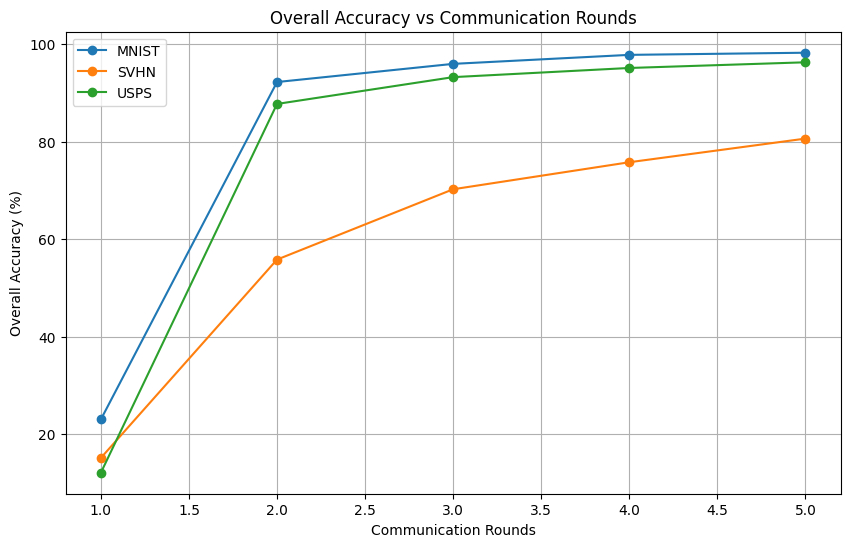

In [76]:
import matplotlib.pyplot as plt

# Extract data from test_accuracies
num_communication_rounds = len(test_accuracies)

# Plot Overall Accuracy vs num_communication_rounds
plt.figure(figsize=(10, 6))
mnist_overall = [test_accuracies[i]['mnist']['overall'] for i in range(num_communication_rounds)]
svhn_overall = [test_accuracies[i]['svhn']['overall'] for i in range(num_communication_rounds)]
usps_overall = [test_accuracies[i]['usps']['overall'] for i in range(num_communication_rounds)]

plt.plot(range(1, num_communication_rounds + 1), mnist_overall, label='MNIST', marker='o')
plt.plot(range(1, num_communication_rounds + 1), svhn_overall, label='SVHN', marker='o')
plt.plot(range(1, num_communication_rounds + 1), usps_overall, label='USPS', marker='o')

plt.xlabel('Communication Rounds')
plt.ylabel('Overall Accuracy (%)')
plt.title('Overall Accuracy vs Communication Rounds')
plt.legend()
plt.grid(True)
plt.show()


# **Class Accuracies vs Number Communication Rounds**

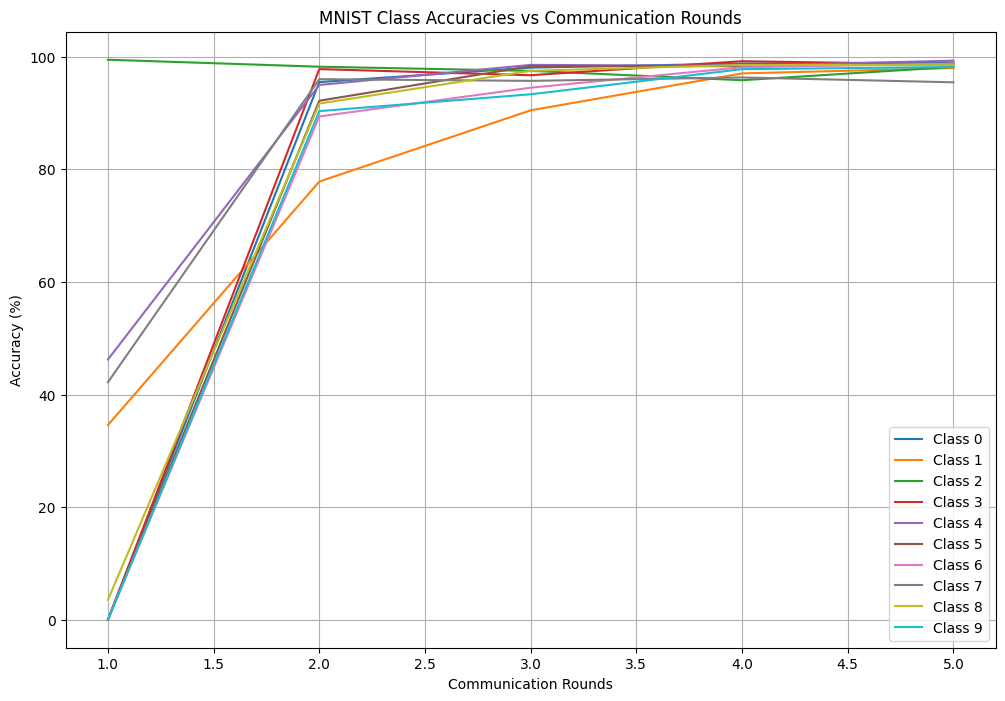

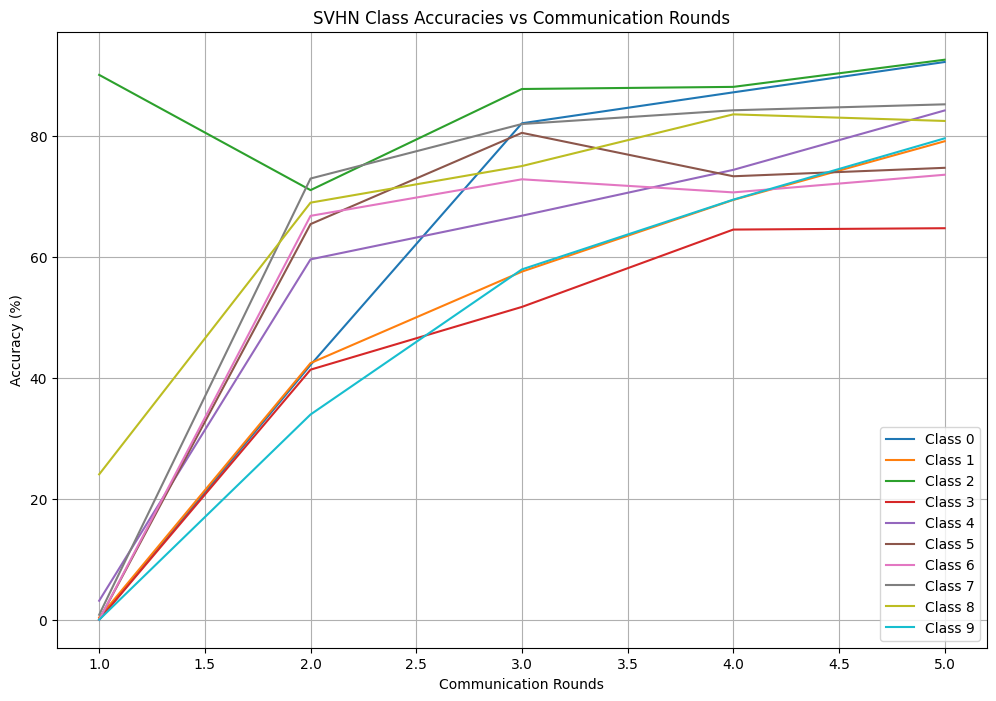

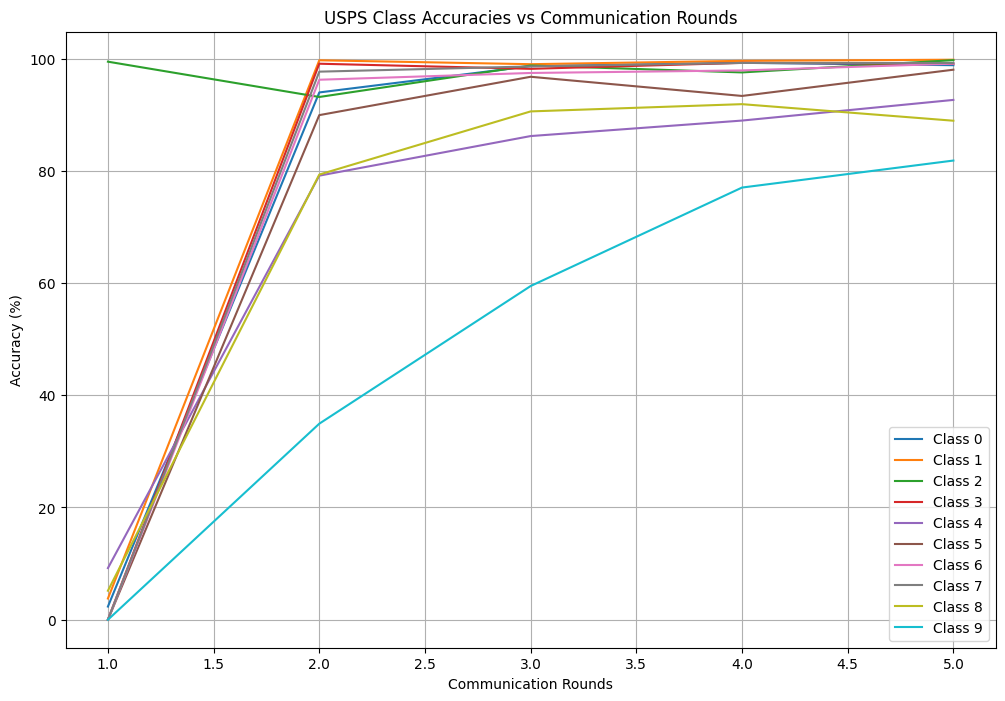

In [77]:
# Plot Class Accuracies vs num_communication_rounds for MNIST
plt.figure(figsize=(12, 8))
for cls in range(10):
    mnist_class_acc = [test_accuracies[i]['mnist']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), mnist_class_acc, label=f'Class {cls}')

plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('MNIST Class Accuracies vs Communication Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot Class Accuracies vs num_communication_rounds for SVHN
plt.figure(figsize=(12, 8))
for cls in range(10):
    svhn_class_acc = [test_accuracies[i]['svhn']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), svhn_class_acc, label=f'Class {cls}')

plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('SVHN Class Accuracies vs Communication Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot Class Accuracies vs num_communication_rounds for USPS
plt.figure(figsize=(12, 8))
for cls in range(10):
    usps_class_acc = [test_accuracies[i]['usps']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), usps_class_acc, label=f'Class {cls}')

plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('USPS Class Accuracies vs Communication Rounds')
plt.legend()
plt.grid(True)
plt.show()


# **Saving Accuracies to a JSON File**

In [79]:
import json

# Convert tensors or non-serializable objects to plain Python types
test_accuracies_serializable = [
    {domain: {'overall': acc['overall'], 'class_acc': [float(ca) for ca in acc['class_acc']]}
     for domain, acc in round_acc.items()}
    for round_acc in test_accuracies
]

# Save as JSON
output_file = "/content/FedClassAvg_75DigitsDataset.json"
with open(output_file, "w") as f:
    json.dump(test_accuracies_serializable, f, indent=4)
print(f"Domain accuracies saved to {output_file}")

Domain accuracies saved to /content/FedClassAvg_75DigitsDataset.json
